In [1]:
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library(tidyverse)
library(devtools)
library("IRdisplay")
library(repr)
options(repr.plot.width=8, repr.plot.height=5.5)

theme_set(theme_bw())
despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(family="Arial", size=17))
options(repr.plot.width=10, repr.plot.height=7)
source("plot_functions.R")

Indlæser krævet pakke: viridisLite

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Indlæser krævet pakke: usethis



In [2]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")
devtools::install_local('../../PtDAlgorithms', quiet=FALSE)
library(ptdalgorithms)

Skipping install of 'ptdalgorithms' from a local remote, the SHA1 (1.0.0) has not changed since last install.
  Use `force = TRUE` to force installation



In [3]:
#load_all("../../PtDAlgorithms")

In [4]:
# #remove.packages("ptdalgorithms")
# devtools::install_github("munch-group/PtDAlgorithms")
# library(ptdalgorithms)

# R code for the coalescent state space

In [5]:
standard_coalescent <- function(n) {
          
    state_vector_length <- n + 1
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(rep(0, n), 0)
    initial_state[1] <- n
    
    add_edge(
      starting_vertex,
      create_vertex(graph, initial_state),
      1
    )
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      
      # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state
          
          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }
          
          # copy state
          child_state <- state
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate, c(rate)
            )
        }
      }
          
      index <- index + 1
    }
    return(graph)
}
graph <- standard_coalescent(4)
graph_update_weights_parameterized(graph, c(0, 0, 0, 0, 0))
graph_as_matrix(graph)

$states
     [,1] [,2] [,3] [,4] [,5]
[1,]    4    0    0    0    0
[2,]    2    1    0    0    0
[3,]    0    2    0    0    0
[4,]    1    0    1    0    0

$SIM
     [,1] [,2] [,3] [,4]
[1,]    0    0    0    0
[2,]    0    0    0    0
[3,]    0    0    0    0
[4,]    0    0    0    0

$IPV
[1] 1 0 0 0

$indices
[1] 2 3 4 5

# Laplace tranform

In the matrix formulation, the Laplace transform for a continuous phase-type distribtion is defined as:

$ E[e^{-\theta \tau}] = \mathbf{\alpha} (\theta\, \mathbf{I} − \mathbf{S})^{−1}\mathbf{s}$ 

where $\mathbf{s}$ is a vector of ones for states with non-zero rates to absorbing states and zeros otherwise. The $\theta$ is time-homogeneous, so it can only represent a global mutation rate if there are only two seuqences. So, here we pretend it is a recombination rate in an ARG and that we are interested in the probability that two loci separated by recombination distance $\theta$ are represented by the same tree in our sample. 

In [6]:
theta <- 0.5

## Casper's code

Specification in matrix terms:

In [24]:
S <- rbind(c(-6, 6, 0, 0), 
           c(0, -3, 1, 2), 
           c(0, 0, -1, 0), 
           c(0, 0, 0, -1))
alpha <- c(1, 0, 0, 0)  # starting state
n <- length(alpha)

Matrix computation of Laplace transform and expected waiting times:

In [25]:
s0 <- - S %*% rep(1, n)
c(solve(theta * diag(n) - S, s0))

[1] 0.5274725 0.5714286 0.6666667 0.6666667

Laplace transform by instead modifying S and the rewards:

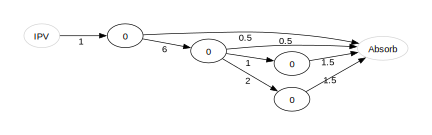

In [26]:
S_new <- S - theta * diag(n)
graph <- matrix_as_graph(alpha, S_new)
plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25)

In [27]:
expected_waiting_time(graph, c(0, s0, 0))

[1] 0.5274725 0.5274725 0.5714286 0.6666667 0.6666667 0.0000000

In [28]:
graph_as_matrix(graph)

$states
     [,1]
[1,]    0
[2,]    0
[3,]    0
[4,]    0

$SIM
     [,1] [,2] [,3] [,4]
[1,] -6.5  6.0  0.0  0.0
[2,]  0.0 -3.5  1.0  2.0
[3,]  0.0  0.0 -1.5  0.0
[4,]  0.0  0.0  0.0 -1.5

$IPV
[1] 1 0 0 0

$indices
[1] 2 3 4 5

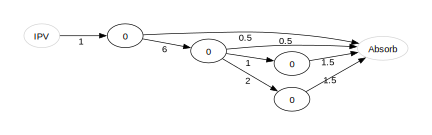

In [30]:
plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25)

In [29]:
expectation(reward_transform(graph, c(0, 0, 0, 1, 1, 0)))

[1] 0.5274725

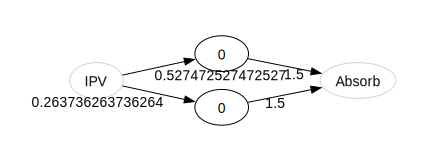

In [31]:
plot_graph(graph_as_matrix(reward_transform(graph, c(0, 0, 0, 1, 1, 0))), fontsize=14, ranksep=1, nodesep=0.25)

## Laplace transformation as graph operations

I wrote a `laplace_transform` R function using the C/C++ backend that makes it easy (and fast) to do the transform inside the graph framework. It modifies the graph inplace and returns the s vector required for rewards to produce the final transformation:

```
laplace_rewards = laplace_transform(graph, theta=0.345)
```

In [14]:
Rcpp::sourceCpp("./cpp/laplace_transform.cpp")

In [15]:
graph <- standard_coalescent(4)
laplace_transform(graph, theta=theta)

[1] 0.7912088

In [104]:
#laplace_transform(graph, theta=0.345)

In [105]:
#laplace_transform(graph, theta=1e-5)

In [106]:
lseq <- function(from=1, to=100000, length.out=6) {
  # logarithmic spaced sequence
  # blatantly stolen from library("emdbook"), because need only this
  exp(seq(log(from), log(to), length.out = length.out))
}

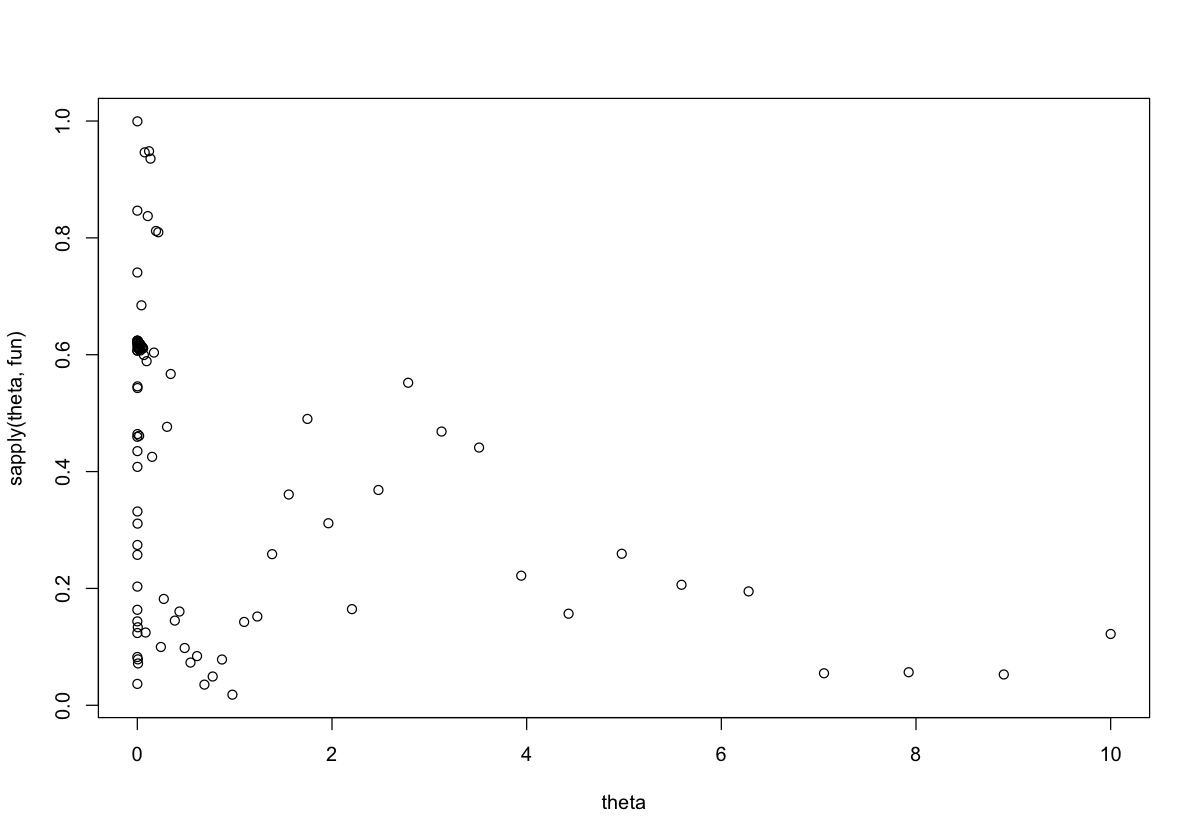

In [14]:
# theta <- seq(1e-6, 2e-6, 1e-7)
theta <- lseq(1e-4, 10, 100)
fun <- function(x) {
    graph <- standard_coalescent(10)
    return(laplace_transform(graph, theta=x))
}
plot(theta, sapply(theta, fun))

In [107]:
graph <- standard_coalescent(4)
laplace_rewards <- rep(0, vertices_length(graph))
abs_parents <- absorbing_parents(graph)
laplace_rewards[absorbing_parents(graph)] <- 1
laplace_rewards

[1] 0 0 0 1 1 0

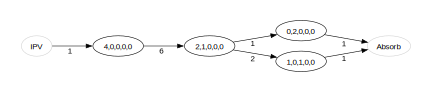

In [108]:
plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25)

In [109]:
graph_as_matrix(graph)

$states
     [,1] [,2] [,3] [,4] [,5]
[1,]    4    0    0    0    0
[2,]    2    1    0    0    0
[3,]    0    2    0    0    0
[4,]    1    0    1    0    0

$SIM
     [,1] [,2] [,3] [,4]
[1,]   -6    6    0    0
[2,]    0   -3    1    2
[3,]    0    0   -1    0
[4,]    0    0    0   -1

$IPV
[1] 1 0 0 0

$indices
[1] 2 3 4 5

In [112]:
graph <- standard_coalescent(4)

laplace_graph <- add_edge_weight_to_absorbing(graph, theta)

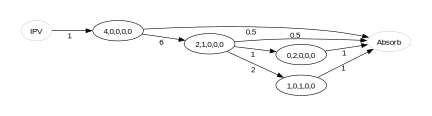

In [113]:
plot_graph(graph_as_matrix(laplace_graph), fontsize=14, ranksep=1, nodesep=0.25)

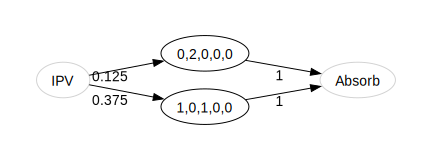

In [84]:
plot_graph(graph_as_matrix(reward_transform(laplace_graph, laplace_rewards)), fontsize=14, ranksep=1, nodesep=0.25)

In [85]:
graph_as_matrix(laplace_graph)

$states
     [,1] [,2] [,3] [,4] [,5]
[1,]    4    0    0    0    0
[2,]    2    1    0    0    0
[3,]    0    2    0    0    0
[4,]    1    0    1    0    0

$SIM
     [,1] [,2] [,3] [,4]
[1,]   -8    6    0    0
[2,]    0   -6    1    3
[3,]    0    0   -1    0
[4,]    0    0    0   -1

$IPV
[1] 1 0 0 0

$indices
[1] 2 3 4 5

In [86]:
expected_waiting_time(laplace_graph, laplace_rewards)

[1] 0.5000000 0.5000000 0.6666667 1.0000000 1.0000000 0.0000000

In [87]:
expectation(laplace_graph, laplace_rewards)

[1] 0.5

In [89]:
laplace_transform(graph, theta=theta)

[1] 0.5

In [ ]:
grid_graph <- function(n) {
          
    state_vector_length <- 2
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(1, 1)
    
    add_edge(
      starting_vertex,
        find_or_create_vertex(graph, initial_state), 1, c(1) ) 
      # create_vertex(graph, initial_state), 1, c(1))  
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)

      state <- vertex$state

      if (0 < state[1] && 0 < state[2]) {

          if (state[1] == state[2]) {
              child_state <- state
              child_state[1] <- 0
              child_state[2] <- 0       
              add_edge(vertex, find_or_create_vertex(graph, child_state), 1, c(1) )                
           }
            
          child_state <- state
          child_state[1] <- child_state[1] + 1
          if (0 < child_state[1] && child_state[1] < n && 0 < child_state[2] && child_state[2] < n) {
              add_edge(vertex, find_or_create_vertex(graph, child_state), 1, c(1))
          }
          child_state <- state
          child_state[1] <- child_state[1] - 1
          if (0 < child_state[1] && child_state[1] < n && 0 < child_state[2] && child_state[2] < n) {
              add_edge(vertex, find_or_create_vertex(graph, child_state), 1, c(1))
          }
          child_state <- state
          child_state[2] <- child_state[2] + 1
          if (0 < child_state[1] && child_state[1] < n && 0 < child_state[2] && child_state[2] < n) {
              add_edge(vertex, find_or_create_vertex(graph, child_state), 1, c(1))
          }
          child_state <- state
          child_state[2] <- child_state[2] - 1
          if (0 < child_state[1] && child_state[1] < n && 0 < child_state[2] && child_state[2] < n) {
              add_edge(vertex, find_or_create_vertex(graph, child_state), 1, c(1))
          }
      }
    index <- index + 1
    }
    return(graph)
}

In [ ]:
graph <- grid_graph(4)
#graph_as_matrix(graph)
vertices_length(graph)

In [ ]:
#plot_graph(graph_as_matrix(graph))

In [ ]:
times <- c()
for (i in 1:10) {
    start <- proc.time()[3]
    expect <- expectation(graph)
#    prob = laplace_transform(graph, theta=3)
    end <- proc.time()[3]
    times <- c(times, (end - start))
}
mean(times)

That way you can take, say, a standard coalescent,

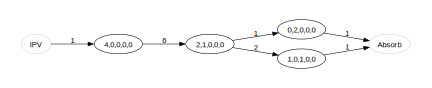

In [19]:
graph <- standard_coalescent(4)
plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25)

add transition from each state to the absorbing state (add edges or add weight to existing ones), 

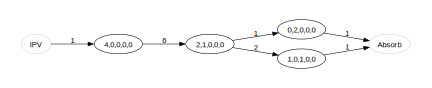

In [20]:
graph <- standard_coalescent(4)
laplace_rewards = laplace_transform(graph, theta=0.345)
plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25)

In [21]:
laplace_rewards

[1] 0.8480955

Using the rewards, we can get expectations beginning in each state,

In [ ]:
expected_waiting_time(graph, laplace_rewards)

or just the normal expectation:

In [ ]:
expectation(graph, laplace_rewards)

The rewards serve to disregard accumulated waiting time at all but the states connected to an absorbing state before the transformation. So to get the graph corresponding to the completed laplace transform, we can just do the reward transformation:

In [ ]:
laplace_graph = reward_transform(graph, laplace_rewards)
plot_graph(graph_as_matrix(laplace_graph), fontsize=14, ranksep=1, nodesep=0.25)

Now it is a continuous phase-type distribution like any other, and we can use all the graph machinery to characterize it:

Expectation:

In [ ]:
expectation(laplace_graph)

Higher moments:

In [ ]:
moments(laplace_graph, 10)

PDF:

In [ ]:
result = data.frame()
for (u in seq(0, 2, 0.5)) {
    graph <- standard_coalescent(4)
    laplace_rewards = laplace_transform(graph, u)
    x <- seq(from = 0, to = 10, by = 0.01)
    pdf <- dph(x, reward_transform(graph, laplace_rewards))
    df <- data.frame(density = pdf, probability=x, u=u)
    result <- rbind(result, df)
}
result %>% ggplot(aes(y=density, x=probability, group=u, color=u)) +
        geom_line(linewidth=1) + scale_color_viridis() + despine

# Guesstimating speed for Kasper's hex grid model

**Runs or connected states (most comparable to hex grid):**

In [ ]:
d <- 1000
S <- matrix(0, d, d)
for (i in 1:d)
    S[i, min(d, i+1):min(d,(i+5))] = 1
diag(S) <- 0
r <- rowSums(S)
r[length(r)] <- r[length(r)] + 1
diag(S) <- -r
#S

In [ ]:
ipv <- c(1, rep(0, d-1))
graph <- matrix_as_graph(ipv, S)
times <- c()
for (i in 1:10) {
    start <- proc.time()[3]
    prob = laplace_transform(graph, theta=3)
    # laplace_rewards = laplace_transform(graph, theta=3)
    # expectation(graph, laplace_rewards)    
    end <- proc.time()[3]
    times <- c(times, (end - start))
}
mean(times)

**Modulo connected states:**

In [ ]:
d <- 1000
S <- matrix(as.integer(1:(d**2) %% 6 == 0), d, d, byrow=TRUE)
diag(S) <- 0
r <- rowSums(S)
r[length(r)] <- r[length(r)] + 1
diag(S) <- -r
#S

In [ ]:
ipv <- c(1, rep(0, d-1))
graph <- matrix_as_graph(ipv, S)
times <- c()
for (i in 1:10) {
    start <- proc.time()[3]
    prob = laplace_transform(graph, theta=3)
    # laplace_rewards = laplace_transform(graph, theta=3)
    # expectation(graph, laplace_rewards)    
    end <- proc.time()[3]
    times <- c(times, (end - start))
}
mean(times)

**Random connected states:**

In [ ]:
d <- 1000
S <- matrix(0, d, d)
for (i in 1:d)
    S[i, sample(1:d, replace=FALSE, size=6)] = 1
diag(S) <- 0
r <- rowSums(S)
r[length(r)] <- r[length(r)] + 1
diag(S) <- -r
#S

In [ ]:
ipv <- c(1, rep(0, d-1))
graph <- matrix_as_graph(ipv, S)
times <- c()
for (i in 1:10) {
    start <- proc.time()[3]
    prob = laplace_transform(graph, theta=3)
    # laplace_rewards = laplace_transform(graph, theta=3)
    # expectation(graph, laplace_rewards)
    end <- proc.time()[3]
    times <- c(times, (end - start))
}
mean(times)

In [ ]:
grid_graph <- function(n) {
          
    state_vector_length <- 2
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(1, 1)
    
    add_edge(
      starting_vertex,
        find_or_create_vertex(graph, initial_state), 1, c(1) ) 
      # create_vertex(graph, initial_state), 1, c(1))  
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)

      state <- vertex$state

      if (0 < state[1] && 0 < state[2]) {

          if (state[1] == state[2]) {
              child_state <- state
              child_state[1] <- 0
              child_state[2] <- 0       
              add_edge(vertex, find_or_create_vertex(graph, child_state), 1, c(1) )                
           }
            
          child_state <- state
          child_state[1] <- child_state[1] + 1
          if (0 < child_state[1] && child_state[1] < n && 0 < child_state[2] && child_state[2] < n) {
              add_edge(vertex, find_or_create_vertex(graph, child_state), 1, c(1))
          }
          child_state <- state
          child_state[1] <- child_state[1] - 1
          if (0 < child_state[1] && child_state[1] < n && 0 < child_state[2] && child_state[2] < n) {
              add_edge(vertex, find_or_create_vertex(graph, child_state), 1, c(1))
          }
          child_state <- state
          child_state[2] <- child_state[2] + 1
          if (0 < child_state[1] && child_state[1] < n && 0 < child_state[2] && child_state[2] < n) {
              add_edge(vertex, find_or_create_vertex(graph, child_state), 1, c(1))
          }
          child_state <- state
          child_state[2] <- child_state[2] - 1
          if (0 < child_state[1] && child_state[1] < n && 0 < child_state[2] && child_state[2] < n) {
              add_edge(vertex, find_or_create_vertex(graph, child_state), 1, c(1))
          }
      }
    index <- index + 1
    }
    return(graph)
}

In [ ]:
#plot_graph(graph_as_matrix(graph))

In [ ]:
#graph_as_matrix(graph)

In [ ]:
graph <- grid_graph(1000)

In [ ]:
vertices_length(graph)

In [ ]:
times <- c()
for (i in 1:10) {
    start <- proc.time()[3]
    # expectation(graph)    
    laplace_rewards = laplace_transform(graph, theta=3)
    expectation(graph, laplace_rewards)    
    end <- proc.time()[3]
    times <- c(times, (end - start))
}
mean(times)